In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import db_connection
import ast
import re

from mysql.connector import Error
from orgelpredigt_analysis import Sermon

import folium

In [2]:
id = "E000007"

In [3]:
cursor, connection = db_connection.get_connection()

In [ ]:
for i in ["E100134", "E100194", "E100033"]:
    try:
        cursor.execute(f"SELECT e10id, e10komponist, e10werk, e10kurztitel, e10textdichter, e10gattung, e10besetzung FROM e10_musikwerke WHERE e10id = '{i}'")
        column_names = [col[0] for col in cursor.description]
        results = cursor.fetchall()
        print(results)
        if results:
            data = [dict(zip(column_names, row))  
                for row in cursor.fetchall()]
            print(data)
        else:
            print(f"Query executed for {i}, but no data found.")
    except Error as e:
        print(f"Database error occurred for {i}:", e)
    except Exception as e:
        print(f"Unexpected error for {i}:", e)



[('E100134', 'Anton, Christoph ; Hintze, Jacob', 'Alle Menschen müssen sterben', '', 'Albinus, Johann Georg ; Rosenmüller, Johann', 'Kirchenlied', '')]
[]
[]
Query executed for E100194, but no data found.
[('E100033', 'Anonym', 'Ach Gott wie manches Herzeleid', '', 'Moller, Martin', 'Kirchenlied', '')]
[]


In [6]:
sermon = Sermon(id)

Unexpected error for E100134: list index out of range
Query executed for E100194, but no data found.
Unexpected error for E100033: list index out of range


In [4]:
cursor, connection = db_connection.get_connection()

In [5]:
def is_id(value):
    pattern = re.compile(r'E[01][0-9]{5}')
    if re.match(pattern, value):
        return True
    else:
        return False

In [6]:
def parse_coords(coord_str):
    try:
        if not coord_str:
            return None
        parts = coord_str.split(';')
        if len(parts) != 2:
            return None
        lon_str = parts[0].strip()
        lat_str = parts[1].strip()
        if lon_str[0] != 'E' or lat_str[0] != 'N':
            return None
        lon = float(lon_str[1:])
        lat = float(lat_str[1:])
        return lat, lon
    except:
        return None

In [7]:
str(sermon.verleger)

'Meder'

In [8]:
import streamlit as st
from streamlit_folium import st_folium

2025-06-21 13:47:06.858 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [9]:
author_network = sermon.autor.get_personal_network()

In [10]:
sermon_locations = {
    sermon.einweihungsort.name : sermon.einweihungsort.koordinaten,
    sermon.verlagsort.name : sermon.verlagsort.koordinaten
}

In [11]:
# create folium Map
map = folium.Map(location=[50.8, 8.7], zoom_start=10)

In [ ]:
# Add markers
for place, coord_str in author_network.items():
    coords = parse_coords(coord_str)
    if coords:
        folium.Marker(location=coords, popup=place, icon=folium.Icon(color='blue', icon='glyphicon-user')).add_to(map)

for place, coord_str in sermon_locations.items():
    coords = parse_coords(coord_str)
    if coords:
        folium.Marker(location=coords, popup=place, icon=folium.Icon(color='red', icon='glyphicon-book')).add_to(map)

map

In [5]:
import plotly.express as px
import math
import pandas

In [15]:
labels

[' bibel', ' quelle', ' bibel quelle', ' quelle literatur', ' literatur', nan]

In [7]:
occurrences = {i:sermon.word_types.count(i) for i in set(sermon.word_types)}

labels = []
data = []
for label, number in occurrences.items():
    if pandas.isnull(label):
    #if math.isnan(int(label)):
        labels.append("text")
    else:
        labels.append(label.strip())
    data.append(number)

fig = px.pie(values=data, names=labels, title='My Pie Chart')
fig.show()

NameError: name 'pandas' is not defined

In [7]:
all_refs = sum(sermon.reference, [])
all_refs

['Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.

In [8]:
len(sermon.words)

10844

In [9]:
for quelle in sermon.literaturzitate:
    print(str(quelle["item"]), quelle["word_share"])

Praetorius, Michael: Syntagmatis Musici Michaelis Praetorii C. Tomus Secundus De Organographia (Wolfenbüttel: 1619) 149
Hilarius [Pictaviensis] ; Gillot, Jean: Sancti Hilarii Pictavorvm Episcopi, quotquot extant Opera (Köln: 1617) 65
Zwinger, Theodor: Theatrvm Hvmanae Vitae Theodori Zuingeri Bas[isliensis] Tertiatione (Basel: [1586]) 412
Plutarch ; Xylander, Wilhelm (Hrsg.): Plutarchi Chaeronensis Moralia, Quae Usurpantur (Frankfurt: 1619) 4
Apollonius, Rhodius: ΑΠΟΛΛΩΝΙΟΥ ΤΟΥ ΡΟΔΙΟΥ ΑΡΓΟΝΑΥΤΙΚΑ (Frankfurt am Main: 1546) 1
Justinus Martyr: Divi Ivstini, Philosophi Ac Martyris Opera (Basel: 1555) 15
Flavius Josephus ; Gelen, Sigmund (Hrsg.) ; Erasmus, Desiderius (Hrsg.): Flavii Iosephi Antiqvitatvm Ivdaicarvm Libri XX (Basel: 1559) 18
Praetorius, Michael: Syntagmatis Musici Michaelis Praetorii C. Tomus Primus (Wittenberg: 1615) 232
Zwinger, Theodor: Theatrvm Hvmanae Vitae Theodori Zuingeri Bas[isliensis] Tertiatione (Basel: [1586]) 30
Universität Wittenberg: Notwendige Antwort/ Auff die

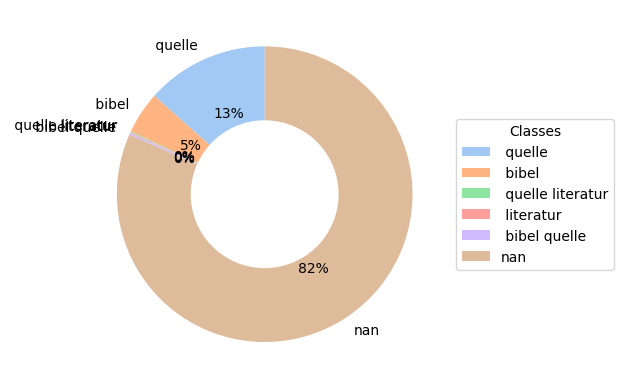

In [10]:
# plotting data on chart
occurrences = {i:sermon.word_types.count(i) for i in set(sermon.word_types)}

labels = []
data = []
for label, number in occurrences.items():
    labels.append(label)
    data.append(number)

colors = sns.color_palette('pastel')

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    data,
    labels=labels,
    colors=colors,
    startangle=90,
    autopct='%.0f%%',
    wedgeprops=dict(width=0.5)
)

ax.legend(wedges, labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()


In [250]:
from pprint import pprint

In [25]:
def generate_quotation_text(words, labels, references):
    text = '<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="UTF-8">\n<meta name="viewport" content="width=device-width, initial-scale=1.0">\n<title>HTML 5 Boilerplate</title><link rel="stylesheet" href="style.css"></head><body><p>'
    for word, label, ref in zip(words, labels, str(references)):
        text += f'<span class="{label}" ref="{ref}">{word}</span> '
    text += '</p></body></html>'
    return text

In [266]:
with open(f'{id}_text_quotes.html', 'w') as f:
    f.write(generate_quotation_text(sermon.words, sermon.word_types, sermon.reference))

In [240]:
labels = sermon.word_types

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

pprint.pprint(list(chunks(range(10, 75), 10)))


[range(10, 20),
 range(20, 30),
 range(30, 40),
 range(40, 50),
 range(50, 60),
 range(60, 70),
 range(70, 75)]


In [26]:
st.title("My Data Analysis App")


2025-06-21 12:38:56.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-21 12:38:56.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-21 12:38:56.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [27]:
st_data = st_folium(map, width=700)

2025-06-21 12:39:21.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-21 12:39:21.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-21 12:39:21.582 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-21 12:39:21.582 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-21 12:39:21.582 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
literaturliste = ""
lit_labels = []
lit_data = []
for quelle in sermon.literaturzitate:
    literaturliste += f"**Werk:** {str(quelle["item"])} **Anteil am Gesamttext:** {quelle["word_share"]/len(sermon.words)}\n\n"
    lit_labels.append(str(quelle["item"]))
    lit_data.append(quelle["word_share"])

custom_labels = [
    f"{label}: {value / len(sermon.words) * 100:.1f}%" if (value / len(sermon.words) * 100) > 5 else ''
    for label, value in zip(lit_labels, lit_data)
]

fig2 = px.pie(values=lit_data, names=lit_labels, title='Verwendete Zitate')



fig2.update_layout(
    width=700,
    height=700,
    margin=dict(t=80, b=50, l=50, r=50),
    title_x=0.5,  # Center title
    legend=dict(
        orientation="h",  # horizontal legend
        y=-0.1  # push legend below chart
    )
)

fig2.show()